# Hourly energy demand generation and weather

This is from the similarly named dataset on [Kaggle](https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather).

There are two data sets, ```energy``` and ```weather```.

## Data Dictionary

For the ```energy``` dataset:

- ```time```: Datetime index localized to CET
- ```generation biomass```: biomass generation in MW
- ```generation fossil coal-derived gass```: coal/lignite generation in MW
- ```generattion fossil coal-derived gass```: coal/gas generation in MW
- ```generation fossil gass```: gas generation in MW
- ```generation fossil hard coal```: coal generation in MW
- ```generation fossil oil```: oil generation in MW
- ```generation fossil oil share```: shale oil generation in MW
- ```generation fossil peat```: peat generation in MW
- ```generation geothermal```: geothermal generatio in MW
- ```generation hydro pumped storage aggregated```: hydro1 generation in MW
- ```generation hydro pumped storage consumption```: hydro 2 generation in MW
- ```generation hydro run-of-river and poundage```: hydro 3 generation in MW
- ```generation hydro water reservoir```: hydro 4 generatio in MW
- ```generation marine```: sea generation in MW
- ```generation nuclear```: nuclear generation in MW
- ```generation other```: other generation in MW
- ```generation other renewable```: other renewable generation in MW
- ```generation solar```: solar generatio in MW
- ```generation waste```: waste generation in MW
- ```generation wind offshore```: wind offshore generation in MW
- ```generation wind onshore```: wind onshore generation in MW
- ```forecast solar day ahead```: forecasted solar generation
- ```forecast wind offshore eday ahead```: forecasted offshore wind generation
- ```forecast wind onshore day ahead```: forecasted onshore wind generation
- ```total load forecast```: forecasted electrical demand
- ```total load actual```: actual electrical demand
- ```price day ahead```: forecasted price in EUR/MWh
- ```price actual```: price in EUR/MWh


And for the ```weather``` dataset:



- ```dt_iso```: datetime index localized to CET
- ```city_name```: name of city
- ```temp```: in Kelvin

- ```temp_min```: minimun in K
- ```temp_max```: maximum in K
- ```pressure```: pressure in hPa
- ```humidity```: humidity in percent
- ```wind_speed```: wind speed in m/s
- ```wind_deg```: wind direction
- ```rain_1h```: rain in last hour in mm
- ```rain_3h```: rain in last 3 hours in mm
- ```snow_3h```: snow in last 3 hours in mm
- ```clouds_all```: cloud cover in percentage
- ```weather_id```: code used to describe weather

- ```weather_main```: short description of current weather
- ```weather_description```: long description of current weather
- ```weather_icon```: weather icon code for website




In [238]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split # For train/test splits
from sklearn.neighbors import KNeighborsRegressor # The k-nearest neighbor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


from sklearn.feature_selection import SelectKBest, VarianceThreshold # feature selection
from sklearn.compose import ColumnTransformer # for dealing with numerical and categorical columns separately
from sklearn.pipeline import Pipeline # For setting up pipeline

# Various pre-processing steps
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV # For optimization




plt.style.use('seaborn-white')
plt.rc('figure', autolayout=True)
plt.rc(
    'axes',
    labelweight='bold',
    labelsize='large',
    titleweight='bold',
    titlesize=9,
    linewidth=4
    )


%matplotlib inline


## Load and Preliminarly Explore the Data

In [2]:
energy = pd.read_csv('energy_dataset.csv')
weather = pd.read_csv('weather_features.csv')

First, let's explore the ```energy``` dataset.

In [3]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
energy.shape

(35064, 29)

In [5]:
energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [6]:
energy_cols = energy.columns.tolist()

for x in energy_cols:
    print(x,': ', energy[x].nunique())

time :  35064
generation biomass :  423
generation fossil brown coal/lignite :  956
generation fossil coal-derived gas :  1
generation fossil gas :  8297
generation fossil hard coal :  7266
generation fossil oil :  321
generation fossil oil shale :  1
generation fossil peat :  1
generation geothermal :  1
generation hydro pumped storage aggregated :  0
generation hydro pumped storage consumption :  3311
generation hydro run-of-river and poundage :  1684
generation hydro water reservoir :  7029
generation marine :  1
generation nuclear :  2388
generation other :  103
generation other renewable :  78
generation solar :  5331
generation waste :  262
generation wind offshore :  1
generation wind onshore :  11465
forecast solar day ahead :  5356
forecast wind offshore eday ahead :  0
forecast wind onshore day ahead :  11332
total load forecast :  14790
total load actual :  15127
price day ahead :  5747
price actual :  6653


In [7]:
print(len(energy_cols[0]))

4


In [8]:
energy.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

The ```energy``` data set has 29 columns and 35064 rows. All columns are float except for the ```time``` column. We should convert that column to a datetime object so we can more easily use the times. Most columns have less than 20 missing values. However, two columns (```generation hydro pumped storage aggregated``` and ```forecast wind offshore eday ahead```) are missing all values. We should remove those columns. A few additional columns have only a single unique value (typically 0). We will remove these columns (```generation fossil coal-derived gas```, ```generation fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, and ```generation wind offshore```) because they do not provide any helpful information.

Finally, we note that the column names have spaces between the words. To make it easier for our coding, we'll replace the spaces with underscores.

Data cleaning tasks for the ```energy``` data set:

- convert the ```time``` column to a datetime object
- remove ```generation hydro pumped storage aggregated``` and ```forecast wind offshore eday ahead```
- remove ```generation fossil coal-derived gas```, ```generation fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, and ```generation wind offshore```
- replace spaces in column names with underscore

In [9]:
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [10]:
weather.shape

(178396, 17)

In [11]:
weather.isnull().sum()

dt_iso                 0
city_name              0
temp                   0
temp_min               0
temp_max               0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
rain_3h                0
snow_3h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
weather_icon           0
dtype: int64

In [12]:
weather_cols = weather.columns.tolist()

for x in weather_cols:
    print(x,': ', weather[x].nunique())

dt_iso :  35064
city_name :  5
temp :  20743
temp_min :  18553
temp_max :  18591
pressure :  190
humidity :  100
wind_speed :  36
wind_deg :  361
rain_1h :  7
rain_3h :  89
snow_3h :  66
clouds_all :  97
weather_id :  38
weather_main :  12
weather_description :  43
weather_icon :  24


In [13]:
weather['city_name'].value_counts()

Madrid        36267
Bilbao        35951
Seville       35557
 Barcelona    35476
Valencia      35145
Name: city_name, dtype: int64

In [14]:
weather.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

The ```weather``` data set has 17 columns and 178396 rows. It is very clean. There are no null values and every column has multiple unique values. There are data included for five cities: Madrid, Bilbao, Seville, Barcelona, and Valencia. Barcelona has a leading space at the beginning that we'll have to be careful with. Each city is included a different number of times, so we'll have to sort out why that is. There are 35064 unique datetimes. That matches the number in the ```energy``` dataset. Hopefully all of these match, but we'll have to check first. The majority of the columns are numeric types. The ```weather_main```, ```weather_description```, and ```weather_icon``` are all objects. These could be useful as a general description of the type of weather, so we will keep all of these for now.  

Data cleaning tasks for the ```weather``` data set:
- convert ```dt_iso``` to a datetime object


## Data Cleaning

Now that we have explored and identified what we need to do for data cleaning, let's implement it for both data sets.

In [15]:
# we will start with the energy dataset

In [16]:

#- convert the ```time``` column to a datetime object
#- remove ```generation hydro pumped storage aggregated``` and ```forecast wind offshore eday ahead```
#- remove ```generation fossil coal-derived gas```, ```generation fossil oil shale```, ```generation fossil peat```, ```generation geothermal```, ```generation marine```, and ```generation wind offshore```
#- replace spaces in column names with underscore

energy['time'] = pd.to_datetime(energy['time'])

columns_to_remove = ['generation hydro pumped storage aggregated','forecast wind offshore eday ahead',
                    'generation fossil coal-derived gas','generation fossil oil shale',
                    'generation fossil peat','generation geothermal',
                    'generation marine','generation wind offshore']

energy_clean = energy.drop(columns_to_remove,axis=1)

energy_clean.columns = energy_clean.columns.str.replace(' ','_')


In [17]:
energy_clean.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,forecast_solar_day_ahead,forecast_wind_onshore_day_ahead,total_load_forecast,total_load_actual,price_day_ahead,price_actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


Now we can clean the weather data set. The only item we need for this is to convert the times to a datetime format.

In [240]:
# and now we can clean the weather dataset

weather['dt_iso'] = pd.to_datetime(weather['dt_iso'],utc=True)

In [241]:
weather.dtypes

dt_iso                 datetime64[ns, UTC]
city_name                           object
temp                               float64
temp_min                           float64
temp_max                           float64
pressure                             int64
humidity                             int64
wind_speed                           int64
wind_deg                             int64
rain_1h                            float64
rain_3h                            float64
snow_3h                            float64
clouds_all                           int64
weather_id                           int64
weather_main                        object
weather_description                 object
weather_icon                        object
dtype: object

## Merging Data

First, we need to find out if the times in both data sets are the same. The times in ```weather``` are repeated, so we need to extract the unique times first.  

After that, we want to fold the ```weather``` data set into the ```energy``` data set. We want to separate out the ```weather``` data by ```city```, then add each relevant column. We should prepend the name of each city to the feature on the new data set, such as ```madrid_temp```. 

In [20]:
weather_unique_times = weather['dt_iso'].unique()
energy_unique_times = energy_clean['time'].unique()

test_times = weather_unique_times == energy_unique_times

In [21]:
np.size(test_times) - np.count_nonzero(test_times)

0

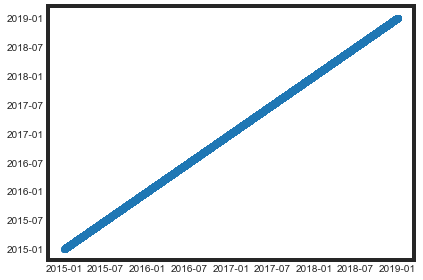

In [22]:
plt.scatter(weather_unique_times,energy_unique_times)
plt.show()

In [23]:
city_names = ['Madrid','Bilbao','Seville',' Barcelona','Valencia']

# let's create an iteration variable so we don't overwrite our data
# we'll use this instead of looking for Madrid so our code is more flexible
iteration = np.linspace(1,len(city_names),num=len(city_names))


for city, it in zip(city_names,iteration):
    # extract only the city for this iteration
    city_extract = weather[weather['city_name'] == city]
    
    # alter the names of the columns to suffix the name of the city
    if city == ' Barcelona':
        city = 'Barcelona' # remove the leading space
    city_suffice = '_' + city
    city_extract = city_extract.add_suffix(city_suffice)
    city_time_col = 'dt_iso_' + city
    
    # merge the dataframes
    if it == 1:
        full_df = energy_clean.merge(city_extract,
                                    left_on='time',right_on=city_time_col,
                                    how='left',suffixes=(None,city))
    else:
        full_df = full_df.merge(city_extract,
                                    left_on='time',right_on=city_time_col,
                                    how='left',suffixes=(None,city))
        

full_df.head()


,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,rain_3h_Valencia,snow_3h_Valencia,clouds_all_Valencia,weather_id_Valencia,weather_main_Valencia,weather_description_Valencia,weather_icon_Valencia
0,2015-01-01 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [24]:
full_df.columns.tolist()

['time',
 'generation_biomass',
 'generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_hydro_water_reservoir',
 'generation_nuclear',
 'generation_other',
 'generation_other_renewable',
 'generation_solar',
 'generation_waste',
 'generation_wind_onshore',
 'forecast_solar_day_ahead',
 'forecast_wind_onshore_day_ahead',
 'total_load_forecast',
 'total_load_actual',
 'price_day_ahead',
 'price_actual',
 'dt_iso_Madrid',
 'city_name_Madrid',
 'temp_Madrid',
 'temp_min_Madrid',
 'temp_max_Madrid',
 'pressure_Madrid',
 'humidity_Madrid',
 'wind_speed_Madrid',
 'wind_deg_Madrid',
 'rain_1h_Madrid',
 'rain_3h_Madrid',
 'snow_3h_Madrid',
 'clouds_all_Madrid',
 'weather_id_Madrid',
 'weather_main_Madrid',
 'weather_description_Madrid',
 'weather_icon_Madrid',
 'dt_iso_Bilbao',
 'city_name_Bilbao',
 'temp_Bilbao',
 'temp

In [25]:
# let's check some of the times to ensure they match up. We'll pick a random integer, 
# then display those times in the dataframe

starting_row = np.random.randint(0,full_df.shape[0])
length = 10 # we'll look at 10 rows at a time

print(full_df.iloc[starting_row:starting_row+length][['time','dt_iso_Valencia']])

#print(starting_row)

                            time            dt_iso_Valencia
34294  2018-07-31 13:00:00+02:00  2018-07-31 13:00:00+02:00
34295  2018-07-31 14:00:00+02:00  2018-07-31 14:00:00+02:00
34296  2018-07-31 15:00:00+02:00  2018-07-31 15:00:00+02:00
34297  2018-07-31 16:00:00+02:00  2018-07-31 16:00:00+02:00
34298  2018-07-31 17:00:00+02:00  2018-07-31 17:00:00+02:00
34299  2018-07-31 18:00:00+02:00  2018-07-31 18:00:00+02:00
34300  2018-07-31 18:00:00+02:00  2018-07-31 18:00:00+02:00
34301  2018-07-31 19:00:00+02:00  2018-07-31 19:00:00+02:00
34302  2018-07-31 19:00:00+02:00  2018-07-31 19:00:00+02:00
34303  2018-07-31 20:00:00+02:00  2018-07-31 20:00:00+02:00


In [26]:
times_cities = ['dt_iso_Valencia','dt_iso_Barcelona','dt_iso_Madrid','dt_iso_Seville','dt_iso_Bilbao']

for x in times_cities:
    time_check = full_df['time'] == full_df[x]
    print(x,np.size(time_check) - np.count_nonzero(time_check))

dt_iso_Valencia 0
dt_iso_Barcelona 0
dt_iso_Madrid 0
dt_iso_Seville 0
dt_iso_Bilbao 0


In [27]:
city_names = ['Madrid','Bilbao','Seville',' Barcelona','Valencia']
iteration = np.linspace(1,len(city_names),num=len(city_names))

#print(iteration)

for city, it in zip(city_names,iteration):
    print(city,it)

Madrid 1.0
Bilbao 2.0
Seville 3.0
 Barcelona 4.0
Valencia 5.0


Finally, let's drop some of the redundant column names to finalize our data set. 

In [28]:
full_df.columns.tolist()

['time',
 'generation_biomass',
 'generation_fossil_brown_coal/lignite',
 'generation_fossil_gas',
 'generation_fossil_hard_coal',
 'generation_fossil_oil',
 'generation_hydro_pumped_storage_consumption',
 'generation_hydro_run-of-river_and_poundage',
 'generation_hydro_water_reservoir',
 'generation_nuclear',
 'generation_other',
 'generation_other_renewable',
 'generation_solar',
 'generation_waste',
 'generation_wind_onshore',
 'forecast_solar_day_ahead',
 'forecast_wind_onshore_day_ahead',
 'total_load_forecast',
 'total_load_actual',
 'price_day_ahead',
 'price_actual',
 'dt_iso_Madrid',
 'city_name_Madrid',
 'temp_Madrid',
 'temp_min_Madrid',
 'temp_max_Madrid',
 'pressure_Madrid',
 'humidity_Madrid',
 'wind_speed_Madrid',
 'wind_deg_Madrid',
 'rain_1h_Madrid',
 'rain_3h_Madrid',
 'snow_3h_Madrid',
 'clouds_all_Madrid',
 'weather_id_Madrid',
 'weather_main_Madrid',
 'weather_description_Madrid',
 'weather_icon_Madrid',
 'dt_iso_Bilbao',
 'city_name_Bilbao',
 'temp_Bilbao',
 'temp

In [29]:
columns_to_drop = ['dt_iso_Madrid','city_name_Madrid',
                  'dt_iso_Bilbao','city_name_Bilbao',
                  'dt_iso_Seville','city_name_Seville',
                  'dt_iso_Barcelona','city_name_Barcelona',
                  'dt_iso_Valencia','city_name_Valencia']

energy_weather = full_df.drop(columns_to_drop,axis=1)

In [80]:
energy_weather['time'] = pd.to_datetime(energy_weather['time'],utc=True)

## Visualizing the Data Set

Now that we have cleaned and merged the data sets, let's do a few simple visualizations so that we can better understand the type and distributions of data we have.

In [33]:
all_columns = energy_weather.columns.tolist()

generation_columns = [x for x in all_columns if x.startswith('generation')]

generation_df = energy_weather[generation_columns]

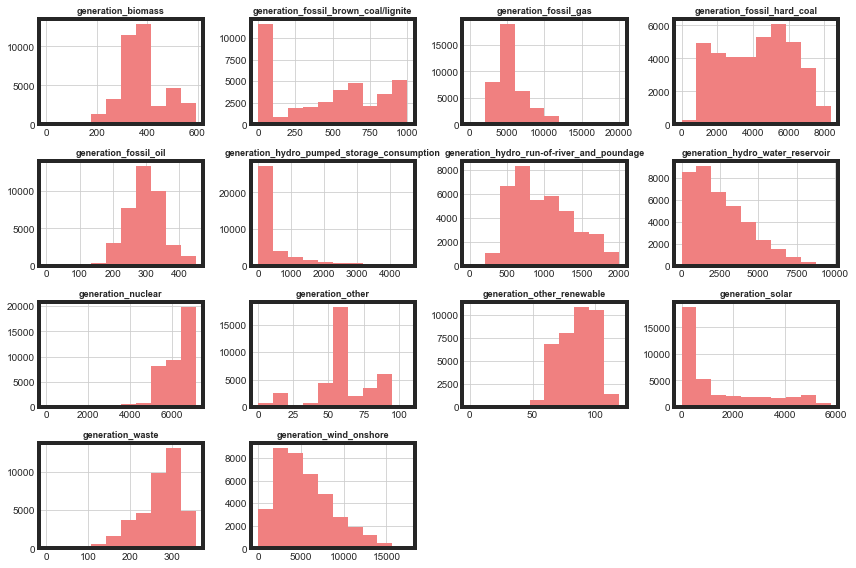

In [164]:

histograms = generation_df.hist(figsize=(12,8),color='lightcoral')
plt.show()



This figure shows the distribution of each ```generation``` column type. The range of each type varies quite significantly. They each have different levels of normal and skew. Three appear as if they have a large number of zero or near-zero values. 

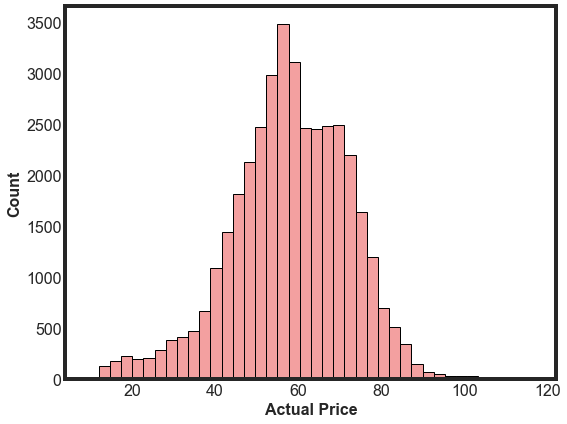

In [176]:
plt.figure(figsize=(8,6))
sns.histplot(energy_weather,x='price_actual',color='lightcoral',
            bins=40)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Actual Price',fontsize=16)
plt.ylabel('Count',fontsize=16)

plt.show()

The ```price_actual``` column will be one of our target values when we build our machine learning model below. It's good practice to visualize the distribution of target values. This distribution looks very close to normal and there are not a lot of outliers, which is great. 

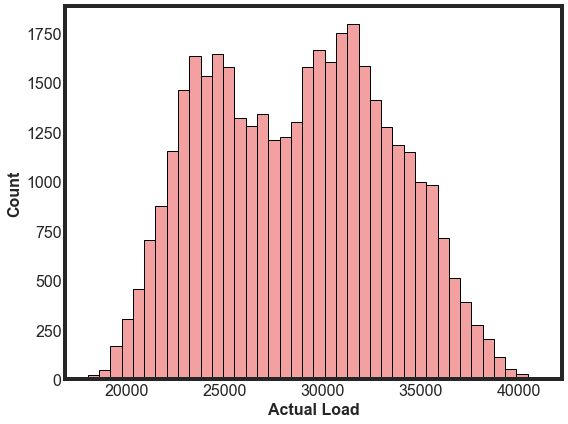

In [272]:
plt.figure(figsize=(8,6))
sns.histplot(energy_weather,x='total_load_actual',color='lightcoral',
            bins=40)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Actual Load',fontsize=16)
plt.ylabel('Count',fontsize=16)

plt.show()



We will also build a model to predict the price based on the weather. This distribution is dual peaked and there are no significant outliers. 

In [65]:
rolling_df = energy_weather.copy()

rolling_df['load_forecast_rolling'] = rolling_df['total_load_forecast'].rolling(30).mean()
rolling_df['load_actual_rolling'] = rolling_df['total_load_actual'].rolling(30).mean()
rolling_df['load_diff'] = rolling_df['load_forecast_rolling'] - rolling_df['load_actual_rolling']

rolling_df['price_day_ahead_rolling'] = rolling_df['price_day_ahead'].rolling(30).mean()
rolling_df['price_actual_rolling'] = rolling_df['price_actual'].rolling(30).mean()
rolling_df['price_diff'] = rolling_df['price_day_ahead_rolling'] - rolling_df['price_actual']



In [54]:
rolling_df.columns

Index(['time', 'generation_biomass', 'generation_fossil_brown_coal/lignite',
       'generation_fossil_gas', 'generation_fossil_hard_coal',
       'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other', 'generation_other_renewable', 'generation_solar',
       'generation_waste', 'generation_wind_onshore',
       'forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead',
       'total_load_forecast', 'total_load_actual', 'price_day_ahead',
       'price_actual', 'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid',
       'pressure_Madrid', 'humidity_Madrid', 'wind_speed_Madrid',
       'wind_deg_Madrid', 'rain_1h_Madrid', 'rain_3h_Madrid', 'snow_3h_Madrid',
       'clouds_all_Madrid', 'weather_id_Madrid', 'weather_main_Madrid',
       'weather_description_Madrid', 'weather_icon_Madrid', 'temp_Bilbao',
       'temp_min_Bilbao

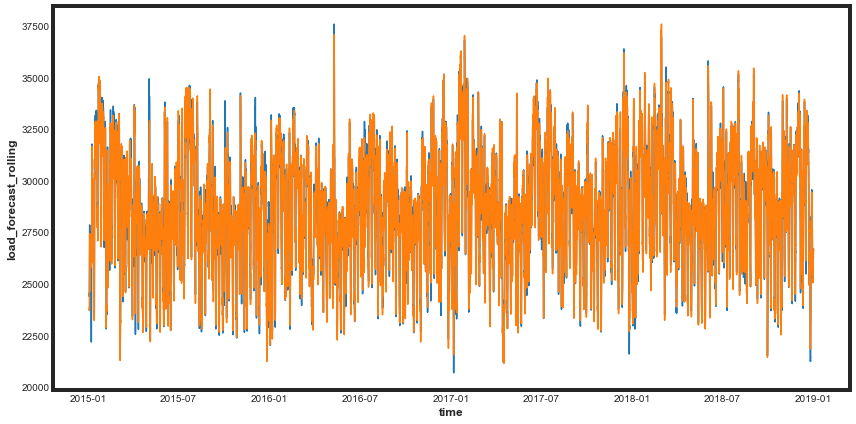

In [61]:
plt.figure(figsize=(12,6))

sns.lineplot(x='time',y='load_forecast_rolling',data=rolling_df)
sns.lineplot(x='time',y='load_actual_rolling',data=rolling_df)

plt.show()

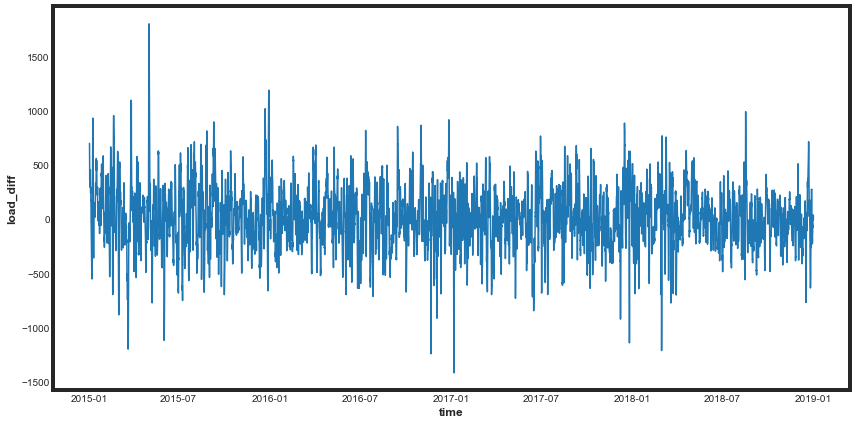

In [63]:
plt.figure(figsize=(12,6))

sns.lineplot(x='time',y='load_diff',data=rolling_df)

plt.show()

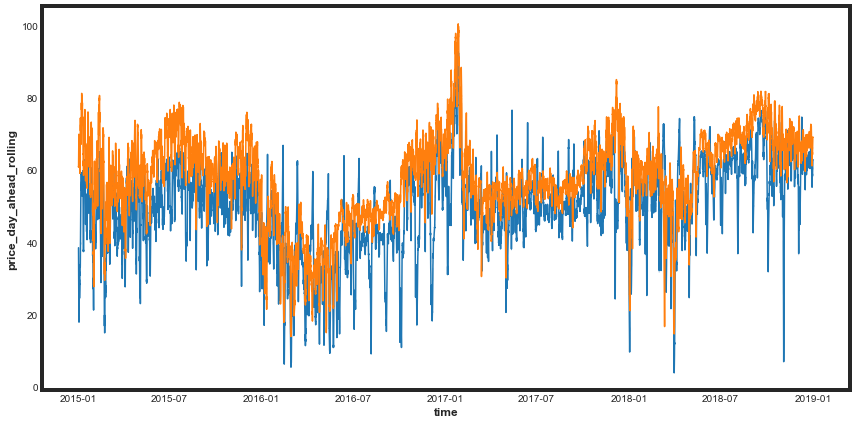

In [66]:
plt.figure(figsize=(12,6))

sns.lineplot(x='time',y='price_day_ahead_rolling',data=rolling_df)
sns.lineplot(x='time',y='price_actual_rolling',data=rolling_df)

plt.show()

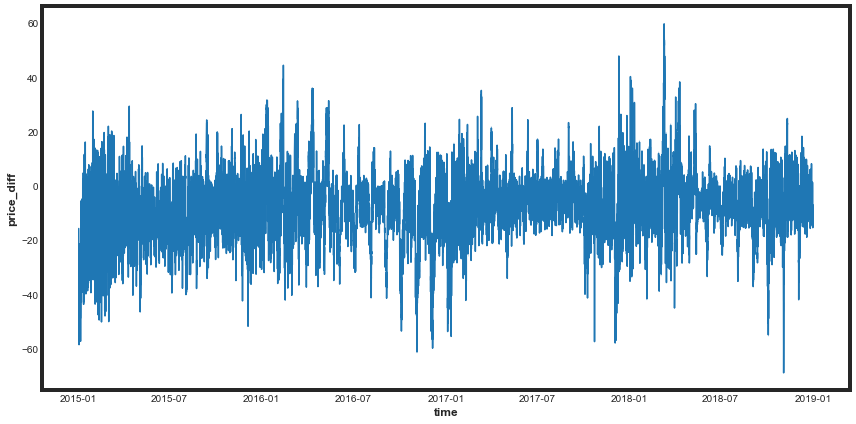

In [67]:
plt.figure(figsize=(12,6))

sns.lineplot(x='time',y='price_diff',data=rolling_df)

plt.show()

In [97]:
energy_columns = ['generation_biomass', 'generation_fossil_brown_coal/lignite',
       'generation_fossil_gas', 'generation_fossil_hard_coal',
       'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other', 'generation_other_renewable', 'generation_solar',
       'generation_waste', 'generation_wind_onshore',
       'forecast_solar_day_ahead', 'forecast_wind_onshore_day_ahead',
       'total_load_forecast', 'total_load_actual', 'price_day_ahead',
       'price_actual']


weather_columns = ['total_load_forecast', 'total_load_actual',
                   'temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid',
       'pressure_Madrid', 'humidity_Madrid', 'wind_speed_Madrid',
       'wind_deg_Madrid', 'rain_1h_Madrid', 'rain_3h_Madrid', 'snow_3h_Madrid',
       'clouds_all_Madrid', 'weather_id_Madrid', 'weather_main_Madrid',
       'weather_description_Madrid', 'weather_icon_Madrid', 'temp_Bilbao',
       'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
       'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao',
       'rain_1h_Bilbao', 'rain_3h_Bilbao', 'snow_3h_Bilbao',
       'clouds_all_Bilbao', 'weather_id_Bilbao', 'weather_main_Bilbao',
       'weather_description_Bilbao', 'weather_icon_Bilbao', 'temp_Seville',
       'temp_min_Seville', 'temp_max_Seville', 'pressure_Seville',
       'humidity_Seville', 'wind_speed_Seville', 'wind_deg_Seville',
       'rain_1h_Seville', 'rain_3h_Seville', 'snow_3h_Seville',
       'clouds_all_Seville', 'weather_id_Seville', 'weather_main_Seville',
       'weather_description_Seville', 'weather_icon_Seville', 'temp_Barcelona',
       'temp_min_Barcelona', 'temp_max_Barcelona', 'pressure_Barcelona',
       'humidity_Barcelona', 'wind_speed_Barcelona', 'wind_deg_Barcelona',
       'rain_1h_Barcelona', 'rain_3h_Barcelona', 'snow_3h_Barcelona',
       'clouds_all_Barcelona', 'weather_id_Barcelona',
       'weather_main_Barcelona', 'weather_description_Barcelona',
       'weather_icon_Barcelona', 'temp_Valencia', 'temp_min_Valencia',
       'temp_max_Valencia', 'pressure_Valencia', 'humidity_Valencia',
       'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
       'rain_3h_Valencia', 'snow_3h_Valencia', 'clouds_all_Valencia',
       'weather_id_Valencia', 'weather_main_Valencia',
       'weather_description_Valencia', 'weather_icon_Valencia']


#energy_weather.columns

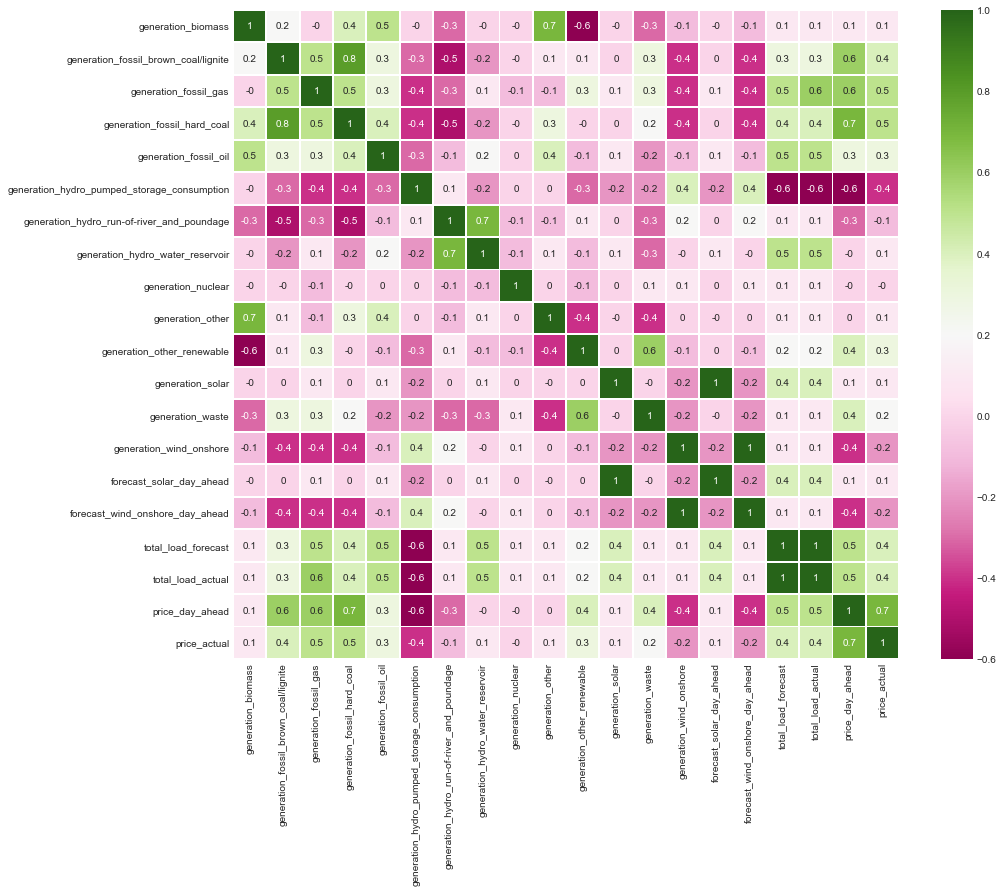

In [98]:
plt.figure(figsize=(15,12.5))

# .corr heatmap of energy columns to visualize correlation & show plot
sns.heatmap(round(energy_weather[energy_columns].corr(),1),annot=True,cmap="PiYG",linewidth=0.9)
plt.show()

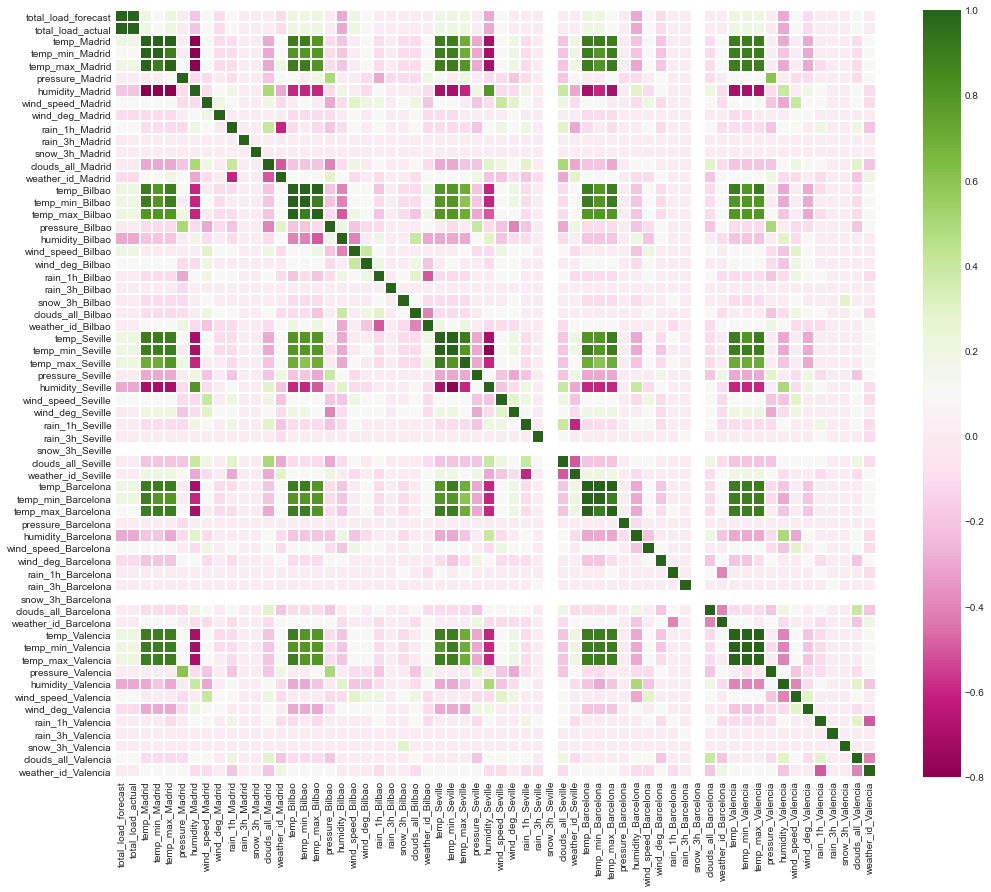

In [100]:
plt.figure(figsize=(15,12.5))

# .corr heatmap of weather columns to visualize correlation & show plot
sns.heatmap(round(energy_weather[weather_columns].corr(),1),annot=False,cmap="PiYG",linewidth=0.9)
plt.show()

There is a high correlation between the temperatures in each city. This is not surprising as Spain is a relatively small county, so we would not expect drastic temperature differences. 

In [70]:
# Correlation of columns to target variable 
correlations = energy_weather.corr(method='pearson')
print(correlations['price_actual'].sort_values(ascending=False).to_string())

price_actual                                   1.000000
price_day_ahead                                0.725112
generation_fossil_gas                          0.460597
generation_fossil_hard_coal                    0.455622
total_load_actual                              0.436529
total_load_forecast                            0.436059
generation_fossil_brown_coal/lignite           0.353297
generation_fossil_oil                          0.277848
generation_other_renewable                     0.264395
pressure_Bilbao                                0.186473
generation_waste                               0.173121
generation_biomass                             0.128552
temp_min_Valencia                              0.120973
generation_other                               0.096990
forecast_solar_day_ahead                       0.096754
generation_solar                               0.093784
temp_min_Barcelona                             0.088266
humidity_Valencia                              0

## Engineering Features

Let's add a column for season. Season will be a better indicator of load and price than exact days or times. We'll create a new column with four categorical values (```winter```, ```spring```, ```summer```, and ```fall```). We could go ahead and enocde these numerically, but for fun we'll save this as a step for our pipeline to do later. 


In [86]:
def add_season(df,datetime_column):
    '''
    function to add season as a column to the dataframe
    
    INPUT:  df: dataframe with a datetime column 
            datetime_column: string, column with datetime values to classify the season
            
    OUTPUT: df: dataframe with new column season with values winter, spring, summer, or fall
    '''
    condition_winter = (df[datetime_column].dt.month>=1)&(df[datetime_column].dt.month<=3)
    condtion_spring = (df[datetime_column].dt.month>=4)&(df[datetime_column].dt.month<=6)
    condition_summer = (df[datetime_column].dt.month>=7)&(df[datetime_column].dt.month<=9)
    condition_fall = (df[datetime_column].dt.month>=10)@(df[datetime_column].dt.month<=12)
    
     # Create column in dataframe that inputs the season based on the conditions created above
    df['season'] = np.where(condition_winter,'winter',
                            np.where(condtion_spring,'spring',
                            np.where(condition_summer,'summer',
                            np.where(condition_fall,'fall',
                                     np.nan))))

    return df
    

In [87]:
season_test = add_season(energy_weather,'time')

## Predicting Price

First, we are going to use this dataset to predict the price of energy. We will not include the full dataframe that we currently have; the weather is not going to change the predicted price. We will also remove the ```time``` column as we will not do any real-time forecasting at this poing.

Our pipeline will need to accomplish a few different tasks:

- imputation - some of our columns have missing values. The majority are missing only 12-14 values, out of the 38568 rows we have. Since we are missing so few, we'll impute values with ```SimpleImputer```
- encoding of categorical values - when we added the ```season``` column, we decided to leave it as categorical. We will need to encode these values to numerical for the modelling. 
- scaling - looking back at the histogram of ```generation``` values above, we see that there is a fairly wide range of possible values that differ by generation type. We'll scale these so that they are more similar, which should improve our accuary. We will try a few different options, including ```StandardScaler```, ```MinMaxScaler```, and ```MaxAbsScaler```.
- feature selection - we have 15 different features we are using to make our predictions. This is not a terribly large number, but each feature might not be helpful for our modelling. We will try a few different feature selection algorithms to help us utilize only the most relevant features. We'll try ```SelectKBest``` and ```Variance Threshold```.
- model selection - finally, we will want to examine a few different models to select which one is best. We will start with comparing ```KNeighborsRegressor``` , ```RandomForestRegressor```, and ```XGBRegressor```.

In [209]:
predicting_price_features = ['generation_biomass', 'generation_fossil_brown_coal/lignite',
       'generation_fossil_gas', 'generation_fossil_hard_coal',
       'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other', 'generation_other_renewable', 'generation_solar',
       'generation_waste', 'generation_wind_onshore',
       'total_load_actual',
       'season']

target = 'price_actual'

Let's set up a pipeline to preprocess and predict the prices

In [210]:
X = energy_weather[predicting_price_features]
y = energy_weather[target]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [215]:
#print(X_train.isnull().sum())
X.shape

(38568, 16)

In [237]:
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler(with_mean=False))]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ('selector', VarianceThreshold()),
           ("regressor", KNeighborsRegressor())]
)

parameters = {'selector': [SelectKBest(), VarianceThreshold()],
              'regressor': [KNeighborsRegressor(),RandomForestRegressor(),XGBRegressor()]
}

grid = GridSearchCV(pipe, parameters, cv=3, scoring='neg_mean_absolute_error').fit(X_train, y_train)

print('Training set score: ' + '{:.4f}'.format(float(grid.score(X_train, y_train))))
print('Test set score: ' + '{:.4f}'.format(float(grid.score(X_test, y_test))))
print('Best model parameters: ' , grid.best_params_)

Training set score: -1.0582
Test set score: -2.7883
Best model parameters:  {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}


Now that we have a baseline score, let's try out a few different scaling methods. Since we have a preprocessor in our pipeline above, it's a little more challenging to iterate over a few different scaling approches. Instead, let's write a for loop to iterate over the scaling types, then save the results to a dictionary that we can compare afterwards. 

In [247]:
scaling_list = [StandardScaler(with_mean=False), MinMaxScaler(), MaxAbsScaler()]
scaling_dict = {}

num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()


for scaler in scaling_list:
    numeric_transformer = Pipeline(
                steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", scaler)]
                )

    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
            ]
            )

    pipe = Pipeline(
            steps=[("preprocessor", preprocessor), 
            ('selector', VarianceThreshold()),
            ("regressor", KNeighborsRegressor())]
            )

    parameters = {'selector': [SelectKBest(), VarianceThreshold()],
                'regressor': [KNeighborsRegressor(),RandomForestRegressor(),XGBRegressor()]
                }

    grid = GridSearchCV(pipe, parameters, cv=3, scoring='neg_mean_absolute_error').fit(X_train, y_train)

    train_score = grid.score(X_train, y_train)
    test_score = grid.score(X_test, y_test)
    best_model = grid.best_params_
    
    print('scaler: ', scaler)
    print('Training set score: ' + '{:.4f}'.format(float(train_score)))
    print('Test set score: ' + '{:.4f}'.format(float(test_score)))
    print('Best model parameters: ' , best_model)
    scaling_dict[scaler] = [train_score,test_score,best_model]


scaler:  StandardScaler(with_mean=False)
Training set score: -1.0621
Test set score: -2.8127
Best model parameters:  {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}
scaler:  MinMaxScaler()
Training set score: -1.0600
Test set score: -2.7998
Best model parameters:  {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}
scaler:  MaxAbsScaler()
Training set score: -1.0555
Test set score: -2.7889
Best model parameters:  {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}


{StandardScaler(with_mean=False): [-1.0586061757661505, -2.7850089960954425, {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}], MinMaxScaler(): [-1.054705902731303, -2.781004041908493, {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}], MaxAbsScaler(): [-1.0577708286184657, -2.7891353688291307, {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}]}


Adding in the season boosted the training score by 2% and the test score by 5%.

The scaling types had very little effect on the test scores. All three scaling types led to the same selector and regression model being selected (Variance Threshhold and the Random Forest Regressor). Comparing the models with different scaling types:

| Scaling Type          | Best Score |
|-------------------------|------------|
| Standard Scaler                | -2.785       |
| MinMax Scaler | -2.781      |
| MaxAbs Scaler   | -2.789      |


## Predicting Load

Now we are going to use our weather-related information to predict the load. This is important for energy companies to ensure they have enough supply so that the grid does not collapse. We'll note at the start that we expect our load predictions to be less accurate than our price predictions. [This review of load forecasting](https://jesit.springeropen.com/articles/10.1186/s43067-020-00021-8) found that, in general, 50% of the forecasted amounts depend on the weather and economics. We are only going to consider the weather at this point in time. 

The snow columns for ```Seville``` and ```Barcelona``` have zero variance, so we will not include them here. The same for 3 hour rain total for ```Madrid```.

Our pipeline will look similar to the one we built to predict the price, but there are a few differences we will want to take into account:

- We don't have any missing values for the features, so we don't need to impute any values. 
- We have quite a few more features (55) than we had when we predicted price (16). Referring to the heat map above, there is a a lot of collinearity between these values. Feature selection will be more important than it was above. 
- The target feature, ```total_load_actual```, is missing 37 values, so we will need to remove those rows from the dataframe before modelling. 


In [265]:
predicting_load_features = ['temp_Madrid', 'temp_min_Madrid', 'temp_max_Madrid', 'pressure_Madrid',
                         'humidity_Madrid', 'wind_speed_Madrid', 'wind_deg_Madrid', 'rain_1h_Madrid',
                         'clouds_all_Madrid',
                         'temp_Bilbao', 'temp_min_Bilbao', 'temp_max_Bilbao', 'pressure_Bilbao',
                         'humidity_Bilbao', 'wind_speed_Bilbao', 'wind_deg_Bilbao', 'rain_1h_Bilbao',
                         'clouds_all_Bilbao', 
                         'temp_Seville', 'temp_min_Seville', 'temp_max_Seville',
                         'pressure_Seville', 'humidity_Seville', 'wind_speed_Seville', 'wind_deg_Seville',
                         'rain_1h_Seville',  'clouds_all_Seville',
                         'temp_Barcelona', 'temp_min_Barcelona', 'temp_max_Barcelona',
                         'pressure_Barcelona', 'humidity_Barcelona', 'wind_speed_Barcelona',
                         'wind_deg_Barcelona', 'rain_1h_Barcelona', 'clouds_all_Barcelona',
                         'temp_Valencia', 'temp_min_Valencia', 'temp_max_Valencia', 'pressure_Valencia',
                         'humidity_Valencia', 'wind_speed_Valencia', 'wind_deg_Valencia', 'rain_1h_Valencia',
                         'clouds_all_Valencia'
                         ]

load_target = 'total_load_actual'



In [266]:
len(predicting_load_features)

45

In [267]:
weather_clean_df = energy_weather.copy()

weather_clean_df = weather_clean_df[weather_clean_df['total_load_actual'].notna()]


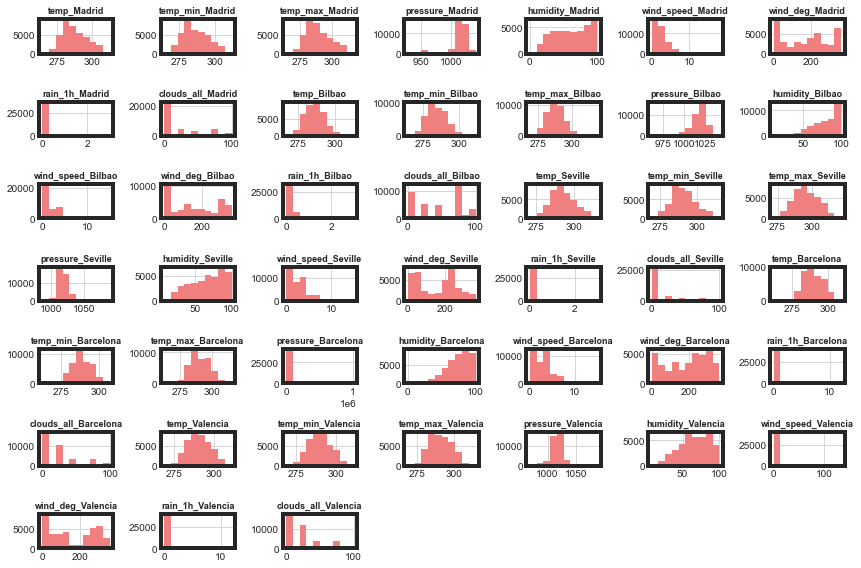

In [268]:
weather_hist = weather_clean_df[predicting_load_features].hist(figsize=(12,8),color='lightcoral')
plt.show()

In [269]:
X_load = weather_clean_df[predicting_load_features]
y_load = weather_clean_df[load_target]

X_train_load, X_test_load, y_train_load, y_test_load = train_test_split(X_load,y_load, test_size=0.2,random_state=0)

In [270]:
#y_load.isnull().sum()
X_load.var().sort_values()

rain_1h_Madrid          5.252370e-02
rain_1h_Seville         5.608134e-02
rain_1h_Valencia        7.399498e-02
rain_1h_Bilbao          1.314174e-01
rain_1h_Barcelona       4.577041e-01
wind_speed_Bilbao       3.608282e+00
wind_speed_Seville      3.692961e+00
wind_speed_Madrid       3.939390e+00
wind_speed_Barcelona    4.002626e+00
wind_speed_Valencia     6.584514e+00
temp_min_Barcelona      4.199713e+01
temp_Barcelona          4.533446e+01
temp_Bilbao             4.553690e+01
temp_min_Bilbao         4.614501e+01
temp_max_Bilbao         4.762630e+01
temp_min_Valencia       4.937878e+01
pressure_Seville        4.945704e+01
temp_Valencia           5.142442e+01
temp_max_Barcelona      5.291523e+01
temp_max_Valencia       5.561487e+01
temp_Seville            6.393430e+01
temp_min_Seville        6.694117e+01
temp_max_Seville        8.137340e+01
temp_min_Madrid         8.298211e+01
temp_Madrid             8.541001e+01
temp_max_Madrid         9.192616e+01
pressure_Bilbao         9.691470e+01
p

In [271]:
pipe_load = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('selector', VarianceThreshold()),
    ('regressor', KNeighborsRegressor())
    ])

parameters_load = {'selector': [SelectKBest(), VarianceThreshold()],
                'regressor': [KNeighborsRegressor(),RandomForestRegressor(),XGBRegressor()]
                }

grid_load = GridSearchCV(pipe_load, parameters_load, cv=3, 
                         scoring='neg_mean_absolute_error').fit(X_train_load, y_train_load)

train_score_load = grid_load.score(X_train_load, y_train_load)
test_score_load = grid_load.score(X_test_load, y_test_load)
best_model_load = grid_load.best_params_

print('Training set score: ' + '{:.4f}'.format(float(train_score_load)))
print('Test set score: ' + '{:.4f}'.format(float(test_score_load)))
print('Best model parameters: ' , best_model_load)



Training set score: -814.9504
Test set score: -2187.6055
Best model parameters:  {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}


There is a bit difference between our training scores and our test scores, about a factor of 3. This is probably an indication that we are overfitting our model. We are already doing cross-validation and using an ensemble model, which are two common ways to correct for overvitting. 

We are currently includeing both the temperature (the meaning of which is unclear but is perhaps the average), the minimum temperature and the maximum temperature. There is a strong collinearity between these values. Let's remove the min and the max from our feature list to ensure they are not being used for the predictions. 

In [274]:
minmax_columns = [x for x in predicting_load_features if 'max' in x or 'min' in x]



['temp_min_Madrid', 'temp_max_Madrid', 'temp_min_Bilbao', 'temp_max_Bilbao', 'temp_min_Seville', 'temp_max_Seville', 'temp_min_Barcelona', 'temp_max_Barcelona', 'temp_min_Valencia', 'temp_max_Valencia']


In [275]:
X_load_no_minmax = X_load.drop(minmax_columns,axis=1)
y_load_no_minmax = weather_clean_df[load_target]

X_train_load_no_minmax, X_test_load_no_minmax, y_train_load_no_minmax, y_test_load_no_minmax = train_test_split(X_load_no_minmax,y_load_no_minmax, test_size=0.2,random_state=0)



In [276]:
pipe_load_no_minmax = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('selector', VarianceThreshold()),
    ('regressor', KNeighborsRegressor())
    ])

parameters_load_no_minmax = {'selector': [SelectKBest(), VarianceThreshold()],
                'regressor': [KNeighborsRegressor(),RandomForestRegressor(),XGBRegressor()]
                }

grid_load_no_minmax = GridSearchCV(pipe_load_no_minmax, parameters_load_no_minmax, cv=3, 
                         scoring='neg_mean_absolute_error').fit(X_train_load_no_minmax, y_train_load_no_minmax)

train_score_load_no_minmax = grid_load_no_minmax.score(X_train_load_no_minmax, y_train_load_no_minmax)
test_score_load_no_minmax = grid_load_no_minmax.score(X_test_load_no_minmax, y_test_load_no_minmax)
best_model_load_no_minmax = grid_load_no_minmax.best_params_

print('Training set score: ' + '{:.4f}'.format(float(train_score_load_no_minmax)))
print('Test set score: ' + '{:.4f}'.format(float(test_score_load_no_minmax)))
print('Best model parameters: ' , best_model_load_no_minmax)


Training set score: -837.3419
Test set score: -2234.2107
Best model parameters:  {'regressor': RandomForestRegressor(), 'selector': VarianceThreshold()}


Removing these values from our features produced no change in our model performance. 

## Conclusion and Next Steps


We are going to wrap up this project for now, but a few next steps we could take to improve our modelling performance could include:

- add information such as economic parameters, historical usage, and household lifestyle to the load predictions.
- categorize the days by month instead of year to add some granularity.
- use the original date times to forecast the price and load 24 hours in advance. We are currently predicting it instantaneously, but it would be more useful to predict both 24 hours in advance.
- tune the hyperparameters of the best feature selectors and models.
